<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/custom_loss/unet_dehaze_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U NET

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam




from math import log10, sqrt
import cv2
from skimage.metrics import structural_similarity as ssim



In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (512, 512), antialias = True)
    img = img / 255.0
    return img

In [12]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.1,validation_size=64,test_size=64,seed_val=900):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b



In [13]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    #print(np.stack(list(train)).shape)
    #train=np.stack(list(train));val=np.stack(list(val))
    return train,val

In [14]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

# **network**

In [15]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return tf.keras.layers.Conv2D(out_channels, kernel_size,padding='same', use_bias=bias)
    
class PixAtLayer(tf.keras.Model):
    def __init__(self, channel):
        super(PixAtLayer, self).__init__()
        self.pa = tf.keras.Sequential()
        self.pa.add(tf.keras.layers.Conv2D(channel // 8, 1, padding='valid',activation='relu'))
        self.pa.add(tf.keras.layers.Conv2D( 1, 1,activation='sigmoid'))
    def call(self, x):
        y = self.pa(x)
        #return y
        return x * y

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

def adapavgpooling(x,outsize):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim1/outsize).astype(np.int32)
    kernels=dim1-(outsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    
    return adpooling

class ChanAtLayer(tf.keras.Model):
  def __init__(self, channel):
      super(ChanAtLayer, self).__init__()
      #self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
      self.ca = tf.keras.Sequential()
      self.ca.add(tf.keras.layers.Conv2D(channel // 8, 1,activation='relu'))
      self.ca.add(tf.keras.layers.Conv2D(channel, 1, activation='sigmoid'))

  def call(self, x):
      y = adapavgpooling(x,1)
      y = self.ca(y)
      #return y
      return x * y

  def model(self):
        x = Input(shape = (412, 548, 64))
        return Model(inputs=[x], outputs=self.call(x))




class dehazenet_attention(tf.keras.Model):
  def __init__(self):
    super(dehazenet_attention, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(input_shape = (412, 548, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv6 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv7 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.pa=PixAtLayer(64)
    self.ca=ChanAtLayer(64)
  def call(self, input_tensor, training=False):
      x1=self.conv1(input_tensor)
      x2=self.conv2(x1)
      concat1 = tf.concat([x1,x2], axis = -1)
      x3=self.conv3(concat1)
      concat2 = tf.concat([x2,x3], axis = -1)
      x4=self.conv4(concat2)
      concat3 = tf.concat([x1,x2,x3,x4], axis = -1)
      K=self.conv5(concat3)
      output1 = ReLU(max_value = 1.0)(tf.math.multiply(K,input_tensor) - K + 1.0)
      #x=self.conv6(output1)
      x=self.pa(output1)
      x=self.conv6(x)
      x=self.ca(x)
      output=self.conv7(x)
      return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [16]:
start_neurons=16
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence

class unet(tf.keras.Model):
    def __init__(self):
      super(unet, self).__init__()
      self.input_layer=tf.keras.layers.experimental.preprocessing.Resizing(512, 512, interpolation="bilinear")
      self.conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")
      self.conv1_1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")
      self.pool1 = MaxPooling2D((2, 2))
      self.pool1_1 = Dropout(0.25)


      self.conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")
      self.conv2_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")
      self.pool2 = MaxPooling2D((2, 2))
      self.pool2_2 = Dropout(0.5)


      self.conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")
      self.conv3_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")
      self.pool3 = MaxPooling2D((2, 2))
      self.pool3_3 = Dropout(0.5)


      self.conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")
      self.conv4_4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")
      self.pool4 = MaxPooling2D((2, 2))
      self.pool4_4 = Dropout(0.5)
      
      self.convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")
      self.convm_1 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")


      self.deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")
      self.uconv4_1 = Dropout(0.5)
      self.uconv4_2 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")
      self.uconv4_3 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")

      self.deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")
      self.uconv3_1 = Dropout(0.5)
      self.uconv3_2 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")
      self.uconv3_3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")

      self.deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")
      self.uconv2_1 = Dropout(0.5)
      self.uconv2_2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")
      self.uconv2_3 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")

      self.deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")
      self.uconv1_1 = Dropout(0.5)
      self.uconv1_2 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")
      self.uconv1_3 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")
      
      self.output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")
      self.output_=tf.keras.layers.experimental.preprocessing.Resizing(412,548,interpolation="bilinear")


    def call(self, input_tensor, training=False):
      #input_layer = tf.keras.Input(shape = [412, 548, 3])(input_tensor)
     
      input_tensor=self.input_layer(input_tensor)
      
      conv1 = self.conv1(input_tensor)
      conv1 = self.conv1_1(conv1)
      pool1 = self.pool1(conv1)
      pool1 = self.pool1_1(pool1,training=training)
      
      conv2 = self.conv2(pool1)
      conv2 = self.conv2_2(conv2)
      pool2 = self.pool2(conv2)
      pool2 = self.pool2_2(pool2,training=training)

      conv3 = self.conv3(pool2)
      conv3 = self.conv3_3(conv3)
      pool3 = self.pool3(conv3)
      pool3 = self.pool3_3(pool3,training=training)

      conv4 = self.conv4(pool3)
      conv4 = self.conv4_4(conv4)
      pool4 = self.pool4(conv4)
      pool4 = self.pool4_4(pool4,training=training)
     
      
      # Middle
      convm =self.convm(pool4)
      convm =self.convm_1(convm)
      
      
      deconv4 =self.deconv4(convm)
      
      uconv4 = concatenate([deconv4, conv4])
      
      uconv4 = self.uconv4_1(uconv4,training=training)
      uconv4 = self.uconv4_2(uconv4)
      uconv4 = self.uconv4_3(uconv4)

      deconv3 =self.deconv3(uconv4)
      uconv3 = concatenate([deconv3, conv3])
      uconv3 = self.uconv3_1(uconv3,training=training)
      uconv3 = self.uconv3_2(uconv3)
      uconv3 = self.uconv3_3(uconv3)

      deconv2 =self.deconv2(uconv3)
      uconv2= concatenate([deconv2, conv2])
      uconv2 = self.uconv2_1(uconv2,training=training)
      uconv2 = self.uconv2_2(uconv2)
      uconv2 = self.uconv2_3(uconv2)

      deconv1 =self.deconv1(uconv2)
      uconv1 = concatenate([deconv1, conv1])
      uconv1 = self.uconv1_1(uconv1,training=training)
      uconv1 = self.uconv1_2(uconv1)
      uconv1 = self.uconv1_3(uconv1)
      

      
      
      output_layer = self.output_layer(uconv1)
      output_layer=self.output_(output_layer)

      return output_layer

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    def build_graph(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [17]:
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()


def gman_net():
    
    inputs = tf.keras.Input(shape = [412, 548, 6])     # height, width of input image changed because of error in output
    #i=tf.image.resize(inputs, size = (412, 548), antialias = True)
    inputs = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
                                    ######################## GMAN Network ###########################
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'valid', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)  
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    
    
                                    #### Encoding Layers #####
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                    #### Residual Layers #####
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers #####
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_output = tf.keras.activations.relu(conc)
    
                               ######################## Parallel Network ###########################
    
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
    conc = tf.add(conv, inputs)
    pn_output = tf.keras.activations.relu(conc)
    
    output = tf.add(gman_output, pn_output)
    
    return Model(inputs = inputs, outputs = output)

In [43]:
class custom_Loss(tf.keras.Model):
  def __init__(self):
      super(custom_Loss, self).__init__()
      self.unet=unet()
      self.dehazenet=dehazenet_attention()
      #self.gman=gman_net()
      self.conv=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')

  def call(self, input_tensor, training=False):
     #x=self.unet(input_tensor,training=training)
     x=self.dehazenet(input_tensor,training=training)
     #y=self.dehazenet(input_tensor,training=training)
     #x= concatenate([x,y])
     #x=self.conv(x)
     x1=self.dehazenet(x)
     '''
     x=self.unet(x,training=training)
     y=self.dehazenet(x,training=training)
     x= concatenate([x,y])

     x=self.unet(x,training=training)
     y=self.dehazenet(x,training=training)
     x= concatenate([x,y])

     x=self.unet(x,training=training)
     y=self.dehazenet(x,training=training)
     x= concatenate([x,y])
     '''
     return x1

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

  def build_graph(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
dehazenet_attention_10 (dehazen (None, 412, 548, 3)  6421        input_11[0][0]                   
                                                                 dehazenet_attention_10[0][0]     
Total params: 6,421
Trainable params: 6,421
Non-trainable params: 0
__________________________________________________________________________________________________


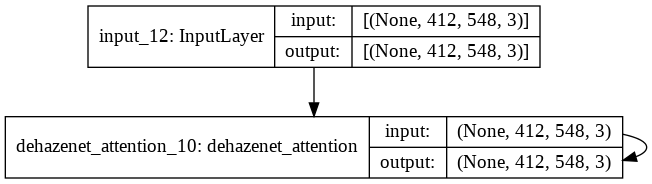

In [44]:
from tensorflow.keras.utils import plot_model
model= custom_Loss()
model.model().summary()

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [45]:
# Hyperparameters
import random
epochs = 8
batch_size = 1


#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = './drive/MyDrive/dataset/clear_images', hazy_img_path = './drive/MyDrive/dataset/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = custom_Loss()
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/test_custom_loss_net',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


1116


In [46]:
a=[];b=[]
class MyLoss_layer(tf.keras.losses.Loss):
    def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.NONE,name='MyLoss_layer'):#=tf.keras.losses.Reduction.AUTO,
        super(MyLoss_layer, self).__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        custom_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        custom_Loss+=1
        return custom_loss



def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    #global a
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):
            #global a
            #a=train_batch_haze
            #global b
            #b=train_batch_orig
            #print(type(train_batch_haze))
            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)
                #loss = MyLoss_layer(train_batch_orig, train_logits)


            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()



In [47]:


%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)




Start of epoch 0 

InternalError: ignored

In [46]:
net.save('./drive/MyDrive/nets/test_custom_loss_net')
model=net
#model.build([412,548,3])
#model.summary()

INFO:tensorflow:Assets written to: ./drive/MyDrive/nets/test_custom_loss_net/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/nets/test_custom_loss_net/assets


In [ ]:
import cv2
import matplotlib.pyplot as plt

def msee(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB):
  # compute the mean squared error and structural similarity
  # index for the images
  m = msee(imageA, imageB)
  s = ssim(imageA, imageB,multichannel=True)
  return s
  #s=tf.image.ssim(imageA, imageB, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
def find_psnr(imageA,imageB):
   return cv2.PSNR(imageA,imageB)

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    
    #random.shuffle(test_img)
    i=1;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        dehaze=tf.image.resize(dehaze, size = (413,550), antialias = True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/test_custom_loss_net'
        
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(filename,im)

        os.chdir('/content')
        i+=1;
    orig_img_path='/content/drive/MyDrive/Final_compare/GT'
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    orig_img.sort()

    test_img_path='/content/drive/MyDrive/Final_compare/test_custom_loss_net'
    
    test_img = glob.glob(test_img_path + '/*.jpg')
    test_img.sort()


    psnr_val=0;ssim_val=0;
    n=len(orig_img)
    for i in range(len(orig_img)):
      os.chdir(orig_img_path)
      original = cv2.imread(orig_img[i]) 
      #original=tf.image.resize_with_crop_or_pad(original, 400, 520)
      original = original[3:-4,3:-4,]
      os.chdir(test_img_path)
      hazy = cv2.imread(test_img[i]) 
      #hazy=tf.image.resize_with_crop_or_pad(hazy, 400, 520)
      hazy=hazy[3:-4,3:-4]
      psnr_val+=find_psnr(original, hazy)
      ssim_val+=compare_images(original, hazy)
      #print(i,end=" ")
    total_psnr=psnr_val/n
    total_ssim=ssim_val/n
    print("\n psnr=",total_psnr)
    print("ssim=",total_ssim)



In [ ]:


new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/test_custom_loss_net',compile=False)


evaluate_gen(new_model)

